In [1]:
import pandas as pd
import os
import re
import numpy as np
import json
import math
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import cv2
import mediapipe as mp

In [2]:
import numpy as np

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def plot_signals(hand, typeTask, path_signal,noem_coef):
    data = json.load(open(path_signal))
    frame = []
    values_distance = []
    values_angle = []
    
    for i in range(len(data)):
        if hand in data[i].keys():
            sum_sqr = (float(data[i][hand]['FORE_TIP']['X1']) - float(data[i][hand]['THUMB_TIP']['X1'])) ** 2 + (float(data[i][hand]['FORE_TIP']['Y1']) - float(data[i][hand]['THUMB_TIP']['Y1'])) ** 2 + (float(data[i][hand]['FORE_TIP']['Z1']) - float(data[i][hand]['THUMB_TIP']['Z1'])) ** 2         
            distance = math.sqrt(sum_sqr)
            values_distance.append(distance)

            x1,y1,z1 = (float(data[i][hand]['THUMB_MCP']['X1'])), (float(data[i][hand]['THUMB_MCP']['Y1'])), (float(data[i][hand]['THUMB_MCP']['Z1']))
            x2,y2,z2 = (float(data[i][hand]['THUMB_TIP']['X1'])), (float(data[i][hand]['THUMB_TIP']['Y1'])), (float(data[i][hand]['THUMB_TIP']['Z1']))
            x3,y3,z3 = (float(data[i][hand]['FORE_TIP']['X1'])), (float(data[i][hand]['FORE_TIP']['Y1'])), (float(data[i][hand]['FORE_TIP']['Z1']))                                                                                                 
            THUMB_MCP_THUMB_TIP = [(x1-x2), (y1-y2), (z1-z2)]
            THUMB_MCP_FORE_TIP =  [(x1-x3), (y1-y3), (z1-z3)]                                                                                  
            values_angle.append(angle_between(THUMB_MCP_THUMB_TIP, THUMB_MCP_FORE_TIP)*noem_coef)
                
                frame.append(data[i]['frame']/100)



    
    return values_distance, values_angle, frame

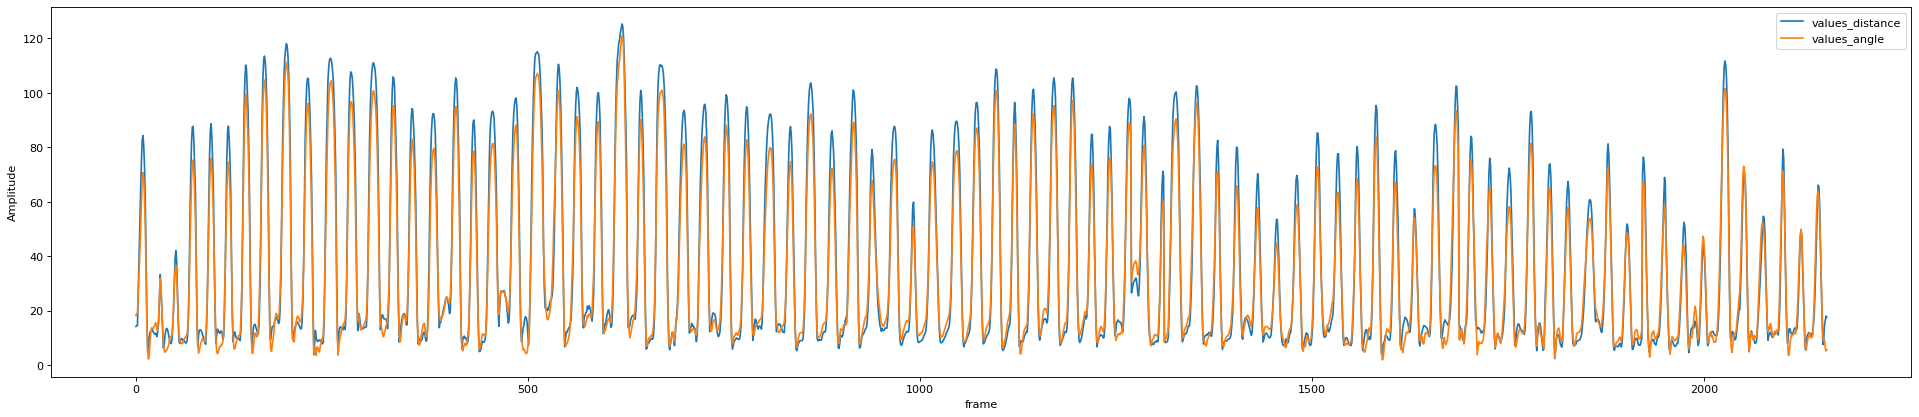

In [3]:
path_signal = r"D:\STUDENTS\student5\r0\hand\leapRecording1_L_m1_student5.json" # здесь должна быть ваша запись с LeapMotion
norm_coef = 120 # подобран так чтобы наложить углы и расстояние на один сигнал 
hand='left hand' #'right hand'
values_distance, values_angle, frame = plot_signals(hand, path_signal, norm_coef)
figure(figsize=(30, 6), dpi=80)
plt.plot(values_distance, label = 'values_distance')
plt.plot(values_angle, label = 'values_angle')
plt.xlabel('frame')
plt.ylabel('Amplitude')
plt.legend()

Запуск веб-камеры для записи координат ладони с помощью mediapipe

In [48]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands
mediapipe_landmarks = []
mediapipe_world_landmarks = []
mediapipe_multi_handedness = []

# For webcam input:
cap = cv2.VideoCapture(0)
with mp_hands.Hands(
    model_complexity=0,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as hands:
  while cap.isOpened():
    success, image = cap.read()
    if not success:
      print("Ignoring empty camera frame.")
      # If loading a video, use 'break' instead of 'continue'.
      continue

    # To improve performance, optionally mark the image as not writeable to
    # pass by reference.
    image.flags.writeable = False
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(image)

    # Draw the hand annotations on the image.
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    if results.multi_hand_landmarks:
      for hand_landmarks in results.multi_hand_world_landmarks:
        mediapipe_world_landmarks.append(hand_landmarks)
      for hand_landmarks in results.multi_handedness:
        mediapipe_multi_handedness.append(hand_landmarks)
      for hand_landmarks in results.multi_hand_landmarks:
        mediapipe_landmarks.append(hand_landmarks)
        mp_drawing.draw_landmarks(
            image,
            hand_landmarks,
            mp_hands.HAND_CONNECTIONS,
            mp_drawing_styles.get_default_hand_landmarks_style(),
            mp_drawing_styles.get_default_hand_connections_style())
    # Flip the image horizontally for a selfie-view display.
    cv2.imshow('MediaPipe Hands', cv2.flip(image, 1))
    if cv2.waitKey(5) & 0xFF == 27:
      break
cap.release()

In [53]:
#дописть реализацию для чтения видео

In [30]:
type(mediapipe_landmarks[0])

mediapipe.framework.formats.landmark_pb2.NormalizedLandmarkList

Перезапись координат mediapipe в список словарей

In [49]:
video_landmarks = []
for i in range(len(mediapipe_landmarks)):
    keypoints = []
    for data_point in mediapipe_landmarks[i].landmark:
        keypoints.append({
                             'X': data_point.x,
                             'Y': data_point.y,
                             'Z': data_point.z,
                             'Visibility': data_point.visibility,
                             })
    video_landmarks.append(keypoints)


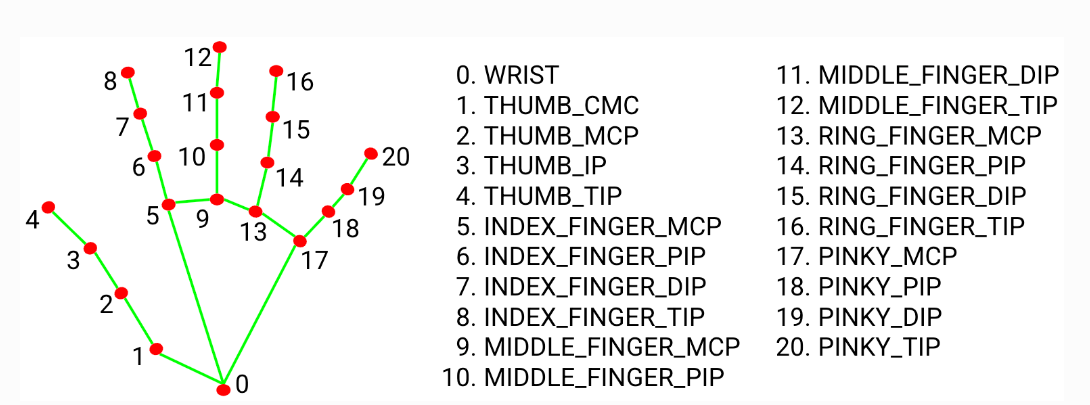

Расчет угла между векторами 0-4, 4-8 https://mediapipe.readthedocs.io/en/latest/solutions/hands.html#multi-handedness

In [50]:
values_angle_mediapipe = []
for frame in video_landmarks:
    x1,y1,z1 = frame[0]['X'], frame[0]['Y'], frame[0]['Z']
    x2,y2,z2 = frame[4]['X'], frame[4]['Y'], frame[4]['Z']
    x3,y3,z3 = frame[8]['X'], frame[8]['Y'], frame[8]['Z']                                                                                             
    THUMB_MCP_THUMB_TIP = [(x1-x2), (y1-y2), (z1-z2)]
    THUMB_MCP_FORE_TIP =  [(x1-x3), (y1-y3), (z1-z3)]                                                                                  
    values_angle_mediapipe.append(angle_between(THUMB_MCP_THUMB_TIP, THUMB_MCP_FORE_TIP))

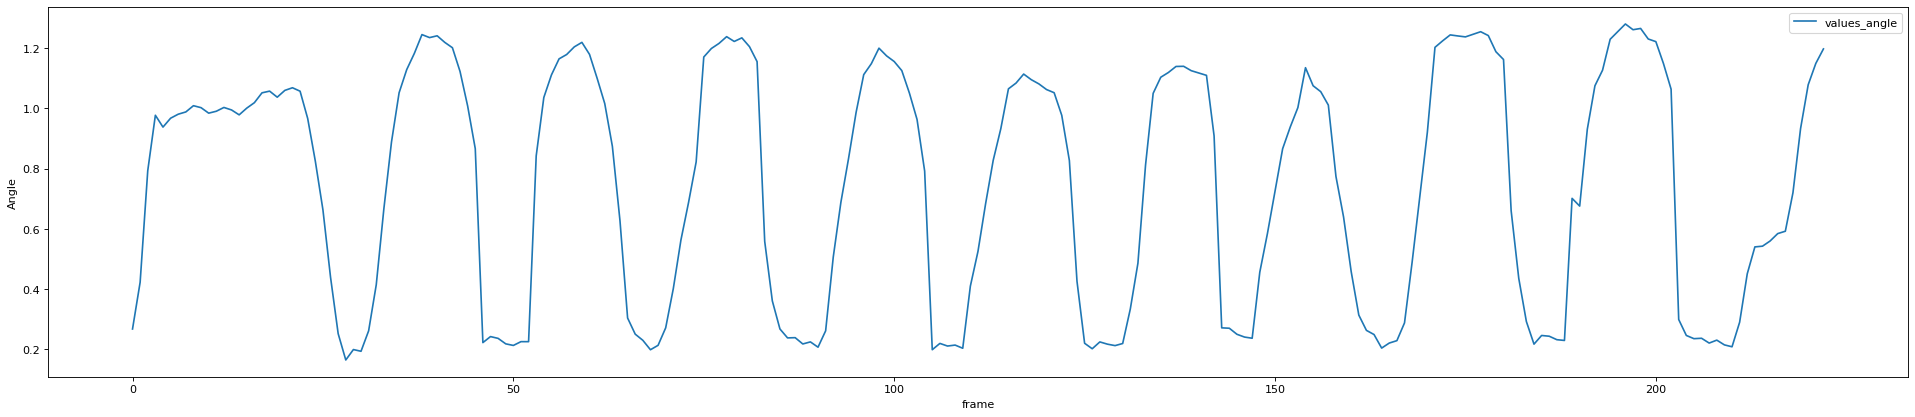

In [51]:
figure(figsize=(30, 6), dpi=80)
plt.plot(values_angle_mediapipe, label = 'values_angle')
plt.xlabel('frame')
plt.ylabel('Angle')
plt.legend()

Задача сравнить с углами Leap Motion при постукивании пальцами:
1. Записать сигналы с LeapMotion и 2D камеры, построить сигналы движения на основе расчета углов между ключевыми векторами, наложить на 1 график
2. Записать сигналы с разным удалением от камеры, с шагом 10 см, построить сигналы
3. Записать сигналы с LM и 2D камерой под разными углами (камера на столе, камера фронтально)
4. Записать сигналы с LM и 2D камерой поворачивая руку под разными углами (от 0 до 90 градусов)